In [1]:
from functools import partial

import equinox as eqx
import jax
import jax.numpy as jnp
import jax.random as jrandom
import matplotlib.pyplot as plt
from jax import lax
from sigkax.kernel import RBFSigKernel
from tqdm.notebook import tqdm

In [2]:
def autocovariance(hurst, n):
    ns_2h = jnp.arange(n + 1) * (2**hurst)
    ret = (ns_2h[:-2] - 2 * ns_2h[1:-1] + ns_2h[2:]) / 2
    return jnp.insert(ret, 0, 1)


def sqrt_eigenvals(hurst, n):
    return jnp.fft.irfft(autocovariance(hurst, n))[:n] ** (0.5)


@partial(jax.jit, static_argnames=["t0", "t1", "dt"])
def fbm_noise(hurst, t0=0, t1=1, dt=1e-2, *, key):

    n = int((t1 - t0) / dt)
    scale = dt**hurst
    m = 2 ** (n - 2).bit_length() + 1
    sq_eig = sqrt_eigenvals(hurst, m)
    scale *= 2**0.5 * (m - 1)

    real_key, imag_key = jrandom.split(key)
    w_real = jrandom.normal(key=real_key, shape=(m,)) * scale
    w_real = w_real.at[0].set(w_real[0] * 2**0.5)
    w_real = w_real.at[-1].set(w_real[-1] * 2**0.5)
    w_imag = jrandom.normal(key=imag_key, shape=(m,)) * scale
    w = lax.complex(w_real, w_imag)
    return jnp.fft.irfft(sq_eig * w)[:n]

In [3]:
def generate_fbm(hurst, n_samples, t0=0.0, t1=1.0, dt=1e-2, *, key):
    keys = jrandom.split(key, n_samples)
    if hurst == 0.5:

        def fn(_key):
            return (
                jrandom.normal(
                    key=_key,
                    shape=(int((t1 - t0) / dt),),
                )
                * dt**hurst
            )

    else:

        def fn(_key):
            return fbm_noise(
                hurst=hurst,
                t0=t0,
                t1=t1,
                dt=dt,
                key=_key,
            )

    delta = jax.vmap(fn)(keys)
    return delta.cumsum(axis=-1)

In [4]:
seed = 0
n_samples = 30
hursts = [0.2, 0.5, 0.8]
dt = 1e-2 / 3
keys = jrandom.split(jrandom.PRNGKey(seed), len(hursts))

paths = []
for hurst, key in zip(hursts, keys):
    paths += [
        0.1
        * generate_fbm(
            hurst=hurst,
            n_samples=n_samples,
            dt=dt,
            key=key,
        )
    ]

paths = jnp.concatenate(paths, axis=0)
paths = jnp.concatenate([jnp.zeros([paths.shape[0], 1]), paths], axis=-1)

In [5]:
# at time to paths
ts = jnp.linspace(0.0, 1, num=paths.shape[-1])[None, :]
ts_tile = jnp.tile(ts, (paths.shape[0], 1))
paths = jnp.stack([paths, ts_tile], axis=-1)

In [6]:
class Herding(eqx.Module):

    n_data: int
    beta: jnp.ndarray
    kernel: RBFSigKernel

    def __init__(self, kernel: RBFSigKernel, n_data, *, key):
        self.kernel = kernel
        self.n_data = n_data
        self.beta = 0.1 * jrandom.normal(key=key, shape=(n_data,))

    def loss(self, xs):
        K = self.kernel.batch_kernel(xs, xs)
        return jnp.dot(
            1.0 / self.n_data - self.beta, K @ (1.0 / self.n_data - self.beta)
        )

In [7]:
kernel = RBFSigKernel(
    log_scale=jnp.array([0.0]),
    log_length_scale=0.5 * jnp.log(jnp.array([0.1])),
    dyadic_order=0,
)
herding = Herding(kernel, n_data=paths.shape[0], key=jrandom.PRNGKey(1))

In [8]:
def soft_thresholding(x, gamma):
    return jax.nn.relu(x - gamma) - jax.nn.relu(-x - gamma)

In [9]:
# do a little test
soft_thresholding(jnp.array([1, 0.1, 0, -0.2, -0.5]), 0.1)

DeviceArray([ 0.9,  0. ,  0. , -0.1, -0.4], dtype=float32)

In [10]:
K = kernel.batch_kernel(paths, paths)


@jax.jit
def loss_fn(beta):

    n = paths.shape[0]
    return jnp.dot(1.0 / n - beta, K @ (1.0 / n - beta))

In [11]:
lr = 1e-2
gamma = 1e-4
losses = []

In [12]:
beta = 0.1 * jrandom.normal(key=jrandom.PRNGKey(0), shape=(paths.shape[0],))

for i in tqdm(range(2000)):
    loss, grad = jax.value_and_grad(loss_fn)(beta)
    losses += [loss.item()]
    # proximal gradient
    beta = soft_thresholding(beta - gamma * grad[0], gamma)

  0%|          | 0/2000 [00:00<?, ?it/s]

In [13]:
selected = jnp.nonzero(jnp.abs(beta) > 0.07)[0]

Text(0.5, 1.0, 'After herdging')

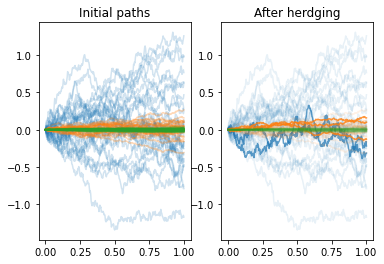

In [14]:
fig, ax = plt.subplots(1, 2)
colors = ["tab:blue", "tab:orange", "tab:green"]
alphas = [0.2, 0.3, 0.4]


def _get_id(i):
    return int(i / n_samples)


for i in range(paths.shape[0]):
    ax[0].plot(
        jnp.linspace(0, 1, paths.shape[1]),
        paths[i, :, 0],
        c=colors[_get_id(i)],
        alpha=alphas[_get_id(i)],
    )

ax[0].set_title("Initial paths")

alphas = [0.7, 0.8, 0.9]
for i in range(paths.shape[0]):
    if i in selected:
        ax[1].plot(
            jnp.linspace(0, 1, paths.shape[1]),
            paths[i, :, 0],
            c=colors[_get_id(i)],
            alpha=alphas[_get_id(i)],
        )
    else:
        ax[1].plot(
            jnp.linspace(0, 1, paths.shape[1]),
            paths[i, :, 0],
            c=colors[_get_id(i)],
            alpha=0.1,
        )

ax[1].set_title("After herdging")

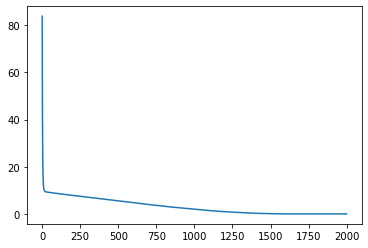

In [15]:
plt.plot(losses)

In [16]:
selected

DeviceArray([ 2, 16, 34, 36, 48], dtype=int32)